# DD2367 - Programming Assignment II: Quantum Circuits and Gates - Bell's Circuit and SWAP Test #

Authors: Scott McHaffie, Jai Iyer, Venkatesh Elayaraja

# Task 1 - State‑Vector Quantum Computer Simulator  #

## 1.1 - State‑vector representation ##

In [1]:
import numpy as np

DTYPE = np.complex128

def ket00():
    """Return |00> as a length‑4 complex column vector."""
    v = np.zeros(4, dtype=DTYPE)
    v[0] = 1.0
    return v

def normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return v / n

# Example
psi = ket00()
print (psi)
assert np.isclose(np.linalg.norm(psi), 1.0), "State is not normalized!"

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


## 1.2 - Quantum gate implementation ##

In [2]:
# 1‑qubit and 2‑qubit gate definitions (matrix form)
I2 = np.array([[1, 0], [0, 1]], dtype=DTYPE)
H  = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=DTYPE)

# CNOT with control = q0 (MSB), target = q1 (LSB) in basis |q0 q1>
CNOT_01 = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
], dtype=DTYPE)

# Expand a 1‑qubit unitary U to a 2‑qubit operator acting on target qubit t in |q0 q1> order
# t = 0 applies to q0 (MSB); t = 1 applies to q1 (LSB)

def expand_1q(U: np.ndarray, t: int) -> np.ndarray:
    if t == 0:   # act on q0 (MSB)
        return np.kron(U, I2) # kronecker product is the tensor product
    elif t == 1: # act on q1 (LSB)
        return np.kron(I2, U)
    else:
        raise ValueError("target index must be 0 or 1")

# Apply a gate matrix to a state vector

def apply(U: np.ndarray, psi: np.ndarray) -> np.ndarray:
    return U @ psi

# Quick unit tests
assert np.allclose(H.conj().T @ H, I2)
assert np.allclose(CNOT_01.conj().T @ CNOT_01, np.eye(4))

## 1.3 - Circuit simulation: Bell state ##

In [3]:
def bell_state() -> np.ndarray:
    psi = ket00()
    # H on q0 (MSB), then CNOT(control=q0, target=q1)
    psi = apply(expand_1q(H, t=0), psi)
    psi = apply(CNOT_01, psi)
    return normalize(psi)

psi_bell = bell_state()
print("Bell state vector:", np.round(psi_bell, 6))
# Expected amplitudes (up to a global phase): [1/√2, 0, 0, 1/√2]
print (psi_bell)

Bell state vector: [0.707107+0.j 0.      +0.j 0.      +0.j 0.707107+0.j]
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


## 1.4 - Output, verification, and circle‑plot comparison ##

{'00': 4983, '01': 0, '10': 0, '11': 5017}


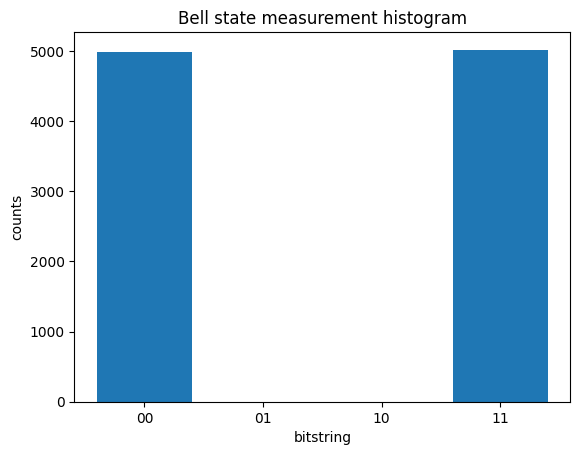

In [4]:
import matplotlib.pyplot as plt

BITSTR = ["00","01","10","11"]

def sample_bitstrings(psi: np.ndarray, shots: int = 10_000, seed: int = 7):
    rng = np.random.default_rng(seed)
    probs = np.abs(psi)**2
    idx = rng.choice(4, size=shots, p=probs)
    return idx

# Sample from Bell state
shots = 10_000
idx = sample_bitstrings(psi_bell, shots=shots)

# Make histogram
counts = {b: int(np.sum(idx == i)) for i, b in enumerate(BITSTR)}
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstring"); plt.ylabel("counts"); plt.title("Bell state measurement histogram")
plt.show()

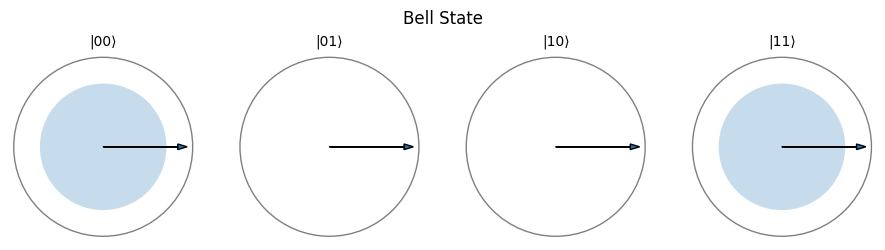

In [5]:
from circleNotationClass import QubitSystem

QubitSystem(psi_bell, label="Bell State").viz_circle()

# Task 2 - State‑Vector SWAP Test  #

# Bonus Tasks - Quantum State Comparison with the Multiqubit SWAP Test #

## B.1 - Basis vs $|5\rangle$: design, simulate, evaluate ##

## B.2 - Introducing superposition ##

# Generative AI Disclosure #

We used ChatGPT-5 and ChatGPT-4 for AI assistance during this assignment. A breakdown of the usage per task is shown below:

1. Task 1: 

2. Task 2: 

3. Bonus: 